#**Harsh Raj A's Coding Task**

#**Preprocessing of the dataset**

In [221]:
import pandas as pd
import numpy as np

In [222]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


 **Loading and importing Dataset**

In [223]:
data = pd.read_csv('/content/drive/MyDrive/Football Data Test Task-DESKTOP-HKE84D6(Raw Data).csv')

In [224]:
data.head()

,Incremental_ID,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,...,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
0,1,E0,8/13/2005,NaN,Aston Villa,Bolton,2,2,D,2,...,2,6,14,16,7,8,0,2,0,0
1,2,E0,8/13/2005,NaN,Everton,Man United,0,2,A,0,...,5,5,15,14,8,6,3,1,0,0
2,3,E0,8/13/2005,NaN,Fulham,Birmingham,0,0,D,0,...,7,4,12,13,6,6,1,2,0,0
3,4,E0,8/13/2005,NaN,Man City,West Brom,0,0,D,0,...,8,3,13,11,3,6,2,3,0,0
4,5,E0,8/13/2005,NaN,Middlesbrough,Liverpool,0,0,D,0,...,2,7,17,11,5,0,2,3,1,0


**converting data to datetime datatype**

In [225]:
data["Date"] = pd.to_datetime(
    data["Date"].astype(str) + " 00:00:00",
    format="%m/%d/%Y %H:%M:%S"
)

**Sorting the data according to data and home team and away team**

In [226]:
data.sort_values(by=["Date","HomeTeam","AwayTeam"],inplace=True)

In [227]:
data.head()

,Incremental_ID,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,...,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
0,1,E0,2005-08-13,NaN,Aston Villa,Bolton,2,2,D,2,...,2,6,14,16,7,8,0,2,0,0
1,2,E0,2005-08-13,NaN,Everton,Man United,0,2,A,0,...,5,5,15,14,8,6,3,1,0,0
2,3,E0,2005-08-13,NaN,Fulham,Birmingham,0,0,D,0,...,7,4,12,13,6,6,1,2,0,0
3,4,E0,2005-08-13,NaN,Man City,West Brom,0,0,D,0,...,8,3,13,11,3,6,2,3,0,0
4,5,E0,2005-08-13,NaN,Middlesbrough,Liverpool,0,0,D,0,...,2,7,17,11,5,0,2,3,1,0


In [228]:
data.shape

(7250, 25)

In [229]:
data.columns

Index(['Incremental_ID', 'Div', 'Date', 'Time', 'HomeTeam', 'AwayTeam', 'FTHG',
       'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR', 'Referee', 'HS', 'AS', 'HST',
       'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR'],
      dtype='object')

**Writing function to get the rolling sum of any window and columns**

In [230]:
import pandas as pd

def assign_season(date):
    """Assign season as Aug–May format."""
    if date.month >= 8:
        return f"{date.year}-{date.year + 1}"
    else:
        return f"{date.year - 1}-{date.year}"

def get_prev_season_avg_goals(data, fthg_col='FTHG', ftag_col='FTAG', window=5):
    results = []

    seasons = sorted(data['Season'].unique())

    for i in range(1, len(seasons)):
        curr_season = seasons[i]
        prev_season = seasons[i - 1]

        curr_data = data[data['Season'] == curr_season].copy()
        prev_data = data[data['Season'] == prev_season].copy()


        home_goals = prev_data[['Date', 'HomeTeam', fthg_col]].copy()
        home_goals.columns = ['Date', 'Team', 'Goals']

        away_goals = prev_data[['Date', 'AwayTeam', ftag_col]].copy()
        away_goals.columns = ['Date', 'Team', 'Goals']

        all_goals = pd.concat([home_goals, away_goals], ignore_index=True)
        all_goals = all_goals.sort_values('Date')


        rolling_avg = (
            all_goals
            .groupby('Team')['Goals']
            .rolling(window=window, min_periods=1)
            .sum()
            .reset_index()
        )


        last_avg_goals = rolling_avg.groupby('Team')['Goals'].last()


        curr_data[f'{fthg_col}_{window}'] = curr_data['HomeTeam'].map(last_avg_goals)
        curr_data[f'{ftag_col}_{window}'] = curr_data['AwayTeam'].map(last_avg_goals)

        results.append(curr_data[['Date', 'HomeTeam', 'AwayTeam', f'{fthg_col}_{window}', f'{ftag_col}_{window}']])

    return pd.concat(results).sort_values(['Date', 'HomeTeam', 'AwayTeam']).reset_index(drop=True)


**To get rolling sum of win,draw,losses**

In [231]:
def get_prev_season_stats(data, fthg_col='FTHG', ftag_col='FTAG', ftr_col='FTR', window=5):
    results = []
    seasons = sorted(data['Season'].unique())

    for i in range(1, len(seasons)):
        curr_season = seasons[i]
        prev_season = seasons[i - 1]

        curr_data = data[data['Season'] == curr_season].copy()
        prev_data = data[data['Season'] == prev_season].copy()

        home_df = prev_data[['Date', 'HomeTeam', fthg_col, ftr_col]].copy()
        home_df['Team'] = home_df['HomeTeam']
        home_df['Win'] = (home_df[ftr_col] == 'H').astype(int)
        home_df['Loss'] = (home_df[ftr_col] == 'A').astype(int)
        home_df['Draw'] = (home_df[ftr_col] == 'D').astype(int)


        away_df = prev_data[['Date', 'AwayTeam', ftag_col, ftr_col]].copy()
        away_df['Team'] = away_df['AwayTeam']
        away_df['Win'] = (away_df[ftr_col] == 'A').astype(int)
        away_df['Loss'] = (away_df[ftr_col] == 'H').astype(int)
        away_df['Draw'] = (away_df[ftr_col] == 'D').astype(int)


        combined = pd.concat([home_df[['Date', 'Team', 'Win', 'Loss', 'Draw']],
                              away_df[['Date', 'Team', 'Win', 'Loss', 'Draw']]])
        combined = combined.sort_values('Date')


        rolling = (
            combined
            .groupby('Team')[[ 'Win', 'Loss', 'Draw']]
            .rolling(window=window, min_periods=1)
            .sum()
            .reset_index()
        )

        last_stats = rolling.groupby('Team').last()


        curr_data[f'HW_{window}'] = curr_data['HomeTeam'].map(last_stats['Win'])
        curr_data[f'HL_{window}'] = curr_data['HomeTeam'].map(last_stats['Loss'])
        curr_data[f'HD_{window}'] = curr_data['HomeTeam'].map(last_stats['Draw'])

        curr_data[f'AW_{window}'] = curr_data['AwayTeam'].map(last_stats['Win'])
        curr_data[f'AL_{window}'] = curr_data['AwayTeam'].map(last_stats['Loss'])
        curr_data[f'AD_{window}'] = curr_data['AwayTeam'].map(last_stats['Draw'])


        results.append(curr_data[[
            'Date', 'HomeTeam', 'AwayTeam', f'HW_{window}', f'HL_{window}',f'HD_{window}',f'AW_{window}', f'AL_{window}', f'AD_{window}'
        ]])

    return pd.concat(results).sort_values(['Date', 'HomeTeam', 'AwayTeam']).reset_index(drop=True)


**adding seasons to the dataset to make the work easy**

In [232]:
data = data.copy()
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values('Date')
data['Season'] = data['Date'].apply(assign_season)

In [233]:
ds = ['FTHG','FTAG', 'HS', 'AS', 'HST','AST','HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR']
nested_pairs = [ds[i:i+2] for i in range(0, len(ds), 2)]
dur = [5,15,38]

In [234]:
summary = data[['Date', 'HomeTeam', 'AwayTeam']].copy()
for i in nested_pairs:
  for j in dur:
    summary = summary.merge(get_prev_season_avg_goals(data, fthg_col=i[0], ftag_col=i[1], window=j),on=['Date', 'HomeTeam', 'AwayTeam'], how='left')

In [235]:
summary.fillna(0,inplace=True)

In [236]:
summary.head()

,Date,HomeTeam,AwayTeam,FTHG_5,FTAG_5,FTHG_15,FTAG_15,FTHG_38,FTAG_38,HS_5,...,HY_15,AY_15,HY_38,AY_38,HR_5,AR_5,HR_15,AR_15,HR_38,AR_38
0,2005-08-13,Aston Villa,Bolton,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2005-08-13,Everton,Man United,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2005-08-13,Fulham,Birmingham,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2005-08-13,Man City,West Brom,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2005-08-13,Middlesbrough,Liverpool,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Merging the datafrane with the original dataFrame**

In [237]:
data = data.merge(summary,on=['Date','HomeTeam','AwayTeam'],how='left')

In [238]:
data.head()

,Incremental_ID,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,...,HY_15,AY_15,HY_38,AY_38,HR_5,AR_5,HR_15,AR_15,HR_38,AR_38
0,1,E0,2005-08-13,NaN,Aston Villa,Bolton,2,2,D,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,E0,2005-08-13,NaN,Everton,Man United,0,2,A,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,E0,2005-08-13,NaN,Fulham,Birmingham,0,0,D,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,E0,2005-08-13,NaN,Man City,West Brom,0,0,D,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,E0,2005-08-13,NaN,Middlesbrough,Liverpool,0,0,D,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**now we are going to find the wins, draws and losses of each home and away team**

In [239]:
stats = data[['Date', 'HomeTeam', 'AwayTeam']].copy()

for j in dur:
    df = get_prev_season_stats(data, window=j)
    stats = stats.merge(df, on=['Date', 'HomeTeam', 'AwayTeam'],how='left')

stats.head()


,Date,HomeTeam,AwayTeam,HW_5,HL_5,HD_5,AW_5,AL_5,AD_5,HW_15,...,HD_15,AW_15,AL_15,AD_15,HW_38,HL_38,HD_38,AW_38,AL_38,AD_38
0,2005-08-13,Aston Villa,Bolton,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2005-08-13,Everton,Man United,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2005-08-13,Fulham,Birmingham,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2005-08-13,Man City,West Brom,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2005-08-13,Middlesbrough,Liverpool,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [240]:
stats.columns

Index(['Date', 'HomeTeam', 'AwayTeam', 'HW_5', 'HL_5', 'HD_5', 'AW_5', 'AL_5',
       'AD_5', 'HW_15', 'HL_15', 'HD_15', 'AW_15', 'AL_15', 'AD_15', 'HW_38',
       'HL_38', 'HD_38', 'AW_38', 'AL_38', 'AD_38'],
      dtype='object')

**Now we are merging the stats of each team with the original data**

In [241]:
data.columns

Index(['Incremental_ID', 'Div', 'Date', 'Time', 'HomeTeam', 'AwayTeam', 'FTHG',
       'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR', 'Referee', 'HS', 'AS', 'HST',
       'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR', 'Season',
       'FTHG_5', 'FTAG_5', 'FTHG_15', 'FTAG_15', 'FTHG_38', 'FTAG_38', 'HS_5',
       'AS_5', 'HS_15', 'AS_15', 'HS_38', 'AS_38', 'HST_5', 'AST_5', 'HST_15',
       'AST_15', 'HST_38', 'AST_38', 'HF_5', 'AF_5', 'HF_15', 'AF_15', 'HF_38',
       'AF_38', 'HC_5', 'AC_5', 'HC_15', 'AC_15', 'HC_38', 'AC_38', 'HY_5',
       'AY_5', 'HY_15', 'AY_15', 'HY_38', 'AY_38', 'HR_5', 'AR_5', 'HR_15',
       'AR_15', 'HR_38', 'AR_38'],
      dtype='object')

In [242]:
data = data.merge(stats,on=['Date','HomeTeam','AwayTeam'],how='left')

**As the data from season 2 will be more prominent we separate the seasons**

In [243]:
start_date = '2005-08-01'
end_date = '2006-05-31'

first_season = data[(data['Date'] >= start_date) & (data['Date'] <= end_date)]


rest_season = data[~((data['Date'] >= start_date) & (data['Date'] <= end_date))]


In [244]:
first_season.head()

,Incremental_ID,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,...,HD_15,AW_15,AL_15,AD_15,HW_38,HL_38,HD_38,AW_38,AL_38,AD_38
0,1,E0,2005-08-13,NaN,Aston Villa,Bolton,2,2,D,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,E0,2005-08-13,NaN,Everton,Man United,0,2,A,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,E0,2005-08-13,NaN,Fulham,Birmingham,0,0,D,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,E0,2005-08-13,NaN,Man City,West Brom,0,0,D,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,E0,2005-08-13,NaN,Middlesbrough,Liverpool,0,0,D,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [245]:
rest_season.head()

,Incremental_ID,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,...,HD_15,AW_15,AL_15,AD_15,HW_38,HL_38,HD_38,AW_38,AL_38,AD_38
380,8,E0,2006-08-19,NaN,West Ham,Charlton,3,1,H,0,...,2.0,4.0,6.0,5.0,16.0,15.0,7.0,13.0,17.0,8.0
381,7,E0,2006-08-19,NaN,Sheffield United,Liverpool,1,1,D,0,...,NaN,12.0,2.0,1.0,NaN,NaN,NaN,25.0,6.0,7.0
382,6,E0,2006-08-19,NaN,Reading,Middlesbrough,3,2,H,2,...,NaN,6.0,7.0,2.0,NaN,NaN,NaN,12.0,17.0,9.0
383,5,E0,2006-08-19,NaN,Portsmouth,Blackburn,3,0,H,1,...,3.0,8.0,5.0,2.0,10.0,20.0,8.0,19.0,13.0,6.0
384,2,E0,2006-08-19,NaN,Bolton,Tottenham,2,0,H,2,...,3.0,7.0,5.0,3.0,15.0,12.0,11.0,18.0,9.0,11.0


In [246]:
rest_season.shape

(6870, 86)

**Droping season and renaming as it wasnt there in original**

In [205]:
rest_season = rest_season.drop(['Season'],axis=1)

In [211]:
rest_season.columns = [col.replace('_', '_L') if any(col.endswith(suffix) for suffix in ['5', '15', '38']) and '_L' not in col else col for col in rest_season.columns]

#**A Basic Random Forrest Classifier model**

**Importing all the required libraries from Scikit-learn**

In [248]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder

**Selecting all numeric column (as this is basic task trying to avoid multiple data encoding)**

In [249]:
features = rest_season.select_dtypes(include=[np.number])
X = features.copy()
y = rest_season['FTR']

**Encoding the target label**

In [250]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)

**Spliting the data**

In [252]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

**Training and fitting the model**

In [253]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

**Showing which feature had the higher importance**

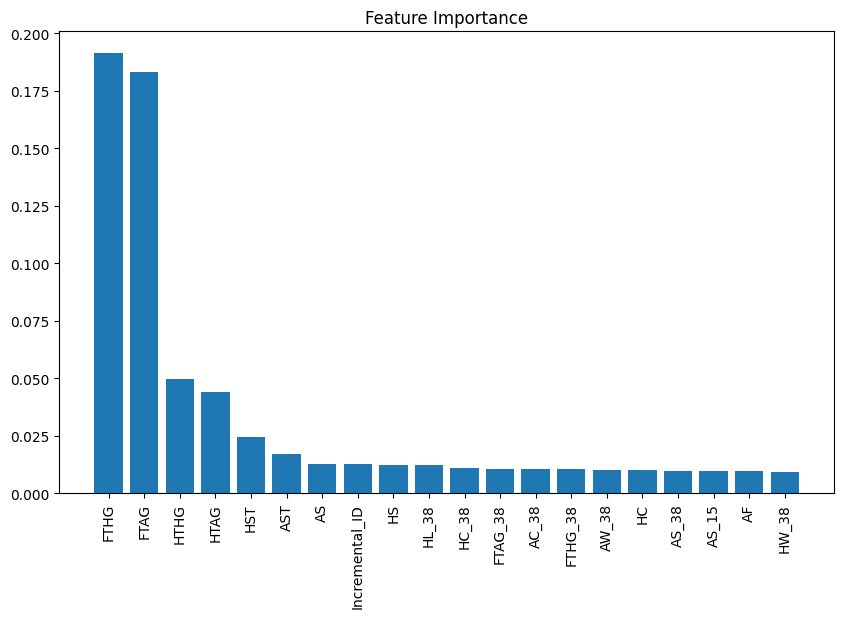

In [255]:
import matplotlib.pyplot as plt

importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
feat_names = X.columns

plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.bar(range(20), importances[indices[:20]])
plt.xticks(range(20), [feat_names[i] for i in indices[:20]], rotation=90)
plt.show()


**Showing the performance matrix and consufion matrix**

In [259]:
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.9475982532751092


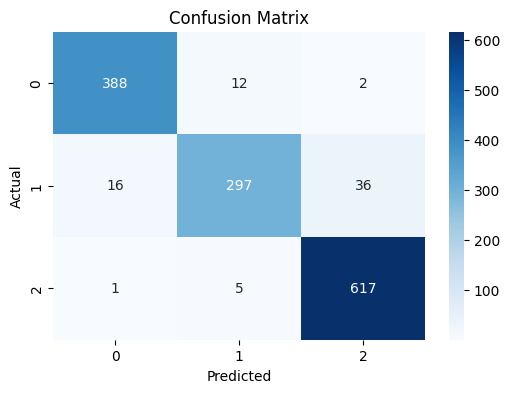

In [260]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred, labels=model.classes_)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

**Saving the last dataframe as a CSV file**

In [265]:
rest_season.sort_values(by=["Date","HomeTeam","AwayTeam"],inplace=True)

<ipython-input-265-d51de63cf8c3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rest_season.sort_values(by=["Date","HomeTeam","AwayTeam"],inplace=True)


In [266]:
rest_season.head()

,Incremental_ID,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,...,HD_15,AW_15,AL_15,AD_15,HW_38,HL_38,HD_38,AW_38,AL_38,AD_38
386,1,E0,2006-08-19,NaN,Arsenal,Aston Villa,1,1,D,0,...,3.0,4.0,7.0,4.0,20.0,11.0,7.0,10.0,16.0,12.0
384,2,E0,2006-08-19,NaN,Bolton,Tottenham,2,0,H,2,...,3.0,7.0,5.0,3.0,15.0,12.0,11.0,18.0,9.0,11.0
385,3,E0,2006-08-19,NaN,Everton,Watford,2,1,H,1,...,6.0,NaN,NaN,NaN,14.0,16.0,8.0,NaN,NaN,NaN
387,4,E0,2006-08-19,NaN,Newcastle,Wigan,2,1,H,1,...,2.0,3.0,7.0,5.0,17.0,14.0,7.0,15.0,17.0,6.0
383,5,E0,2006-08-19,NaN,Portsmouth,Blackburn,3,0,H,1,...,3.0,8.0,5.0,2.0,10.0,20.0,8.0,19.0,13.0,6.0


In [267]:
rest_season.to_csv('my_manipulated_data.csv', index=True)